In [3]:
# wget --http-user=bsip --http-password=bsip2016 -r -np -nH --cut-dirs=2 -R index.html https://lbcsi.fri.uni-lj.si/OBSS/Data/CTMRI/<dodaj_podmape_po_želji> && find . -name "index.html*" -type f -delete


# 2.f (60) Detecting contours of human organs in CT images using the Canny edge detector

The image files, located in individual sub-folders of each patient of the CTMRI DB, show a certain part of the patient's body.  

Your task is to write a program for detecting contours of human organs in the CT images from the CTMRI DB using the Canny edge detector. To fully complete the assignment you have to satisfy several requirements:  
- The program has to accept the name of a CT image (a .png file of the database) as a parameter.  
- The program has to detect edges in the image using the Canny edge detector.  
  - You have to determine both thresholds of the detector empirically. Then, the program has to perform edge linking in the image containing detected edges.  
  - (Instruction: during edge linking there is no need to calculate the gradient magnitude and angle arrays.)  
- The output of the program is a binarized image after edge linking.  
- Store the binarized output image into the .png file. T 
- he program has to display the original image, the image after detecting edges and the final image after edge linking.  
- The program has to be tested using at least four different images from the CTMRI DB.  
- Your discussions and conclusions regarding the use of the Canny edge detector for the task of edge detection in the CT images have to be submitted in a text (.txt) file.  
  - The .txt file together with the source of your program has to be submitted during uploading the assignment.


In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy 

(512, 512, 1)


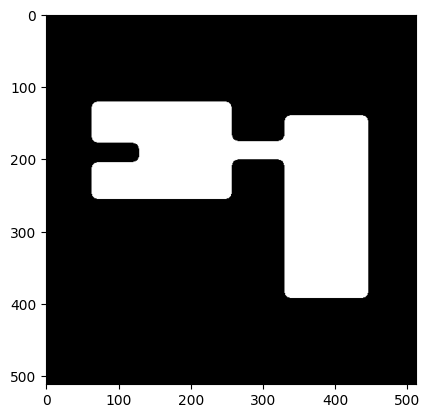

In [5]:
TEST_IMG = "CTMRI/test/test.png"
# TEST_IMG = "CTMRI/A/B/2/0019.png"
test_img_arr = cv.imread(TEST_IMG)
gs_img = cv.cvtColor(test_img_arr, cv.COLOR_RGB2GRAY)[:,:,np.newaxis]
print(gs_img.shape)
plt.imshow(gs_img, cmap="gray")

# Gausian kernel for bluring

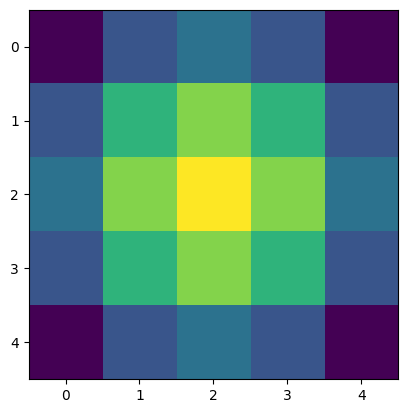

In [6]:
def gaussuian_filter(kernel_size, sigma=1, muu=0):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
 
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2)
 
    # lower normal part of gau
    normal = 1.0/(2 * np.pi * sigma**2)
 
    # Calculating Gaussian filter
    gaus = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
    return gaus[:,:,np.newaxis]

plt.imshow(gaussuian_filter(5))
plt.savefig("gausian_kernel.png")

## different levels of blur

/tmp/ipykernel_124098/4288832279.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


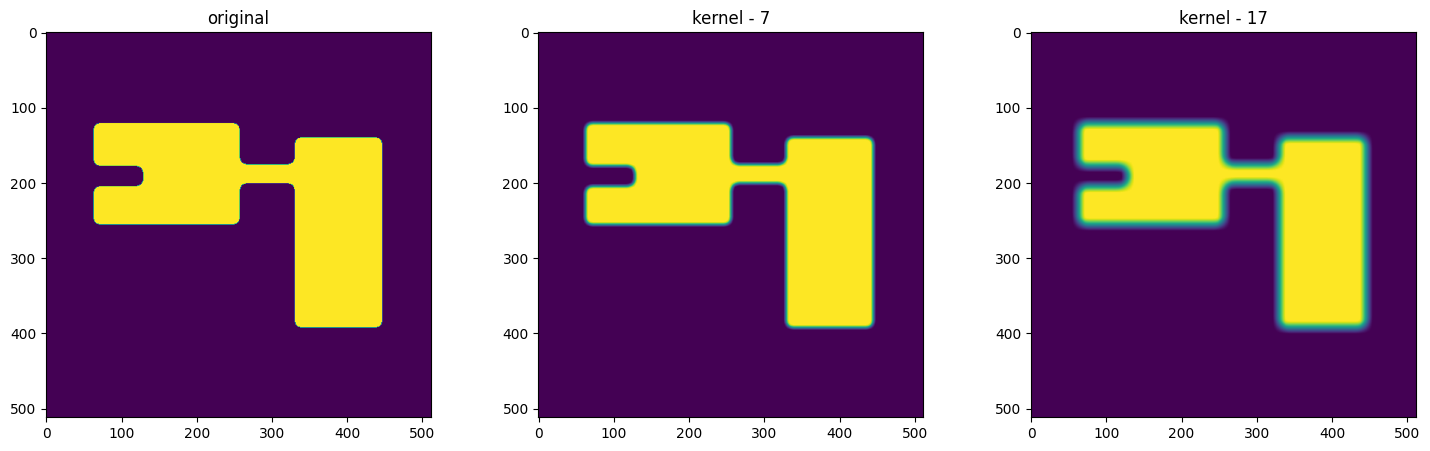

In [7]:
def blur(image:np.ndarray, size=4) -> np.ndarray:
  img = cv.filter2D(image, 2, gaussuian_filter(size))
  return img

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

# orig
ax1.set_title("original")
ax1.imshow(gs_img)

size = 7
ax2.set_title(f"kernel - {size}")
img = blur(gs_img, size=size)
ax2.imshow(img)

size = 17
ax3.set_title(f"kernel - {size}")
img = blur(gs_img, size)
ax3.imshow(img)

fig.savefig("blur_levels.png")
fig.show()


# Sobel kernels for X and Y edge detection  


[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


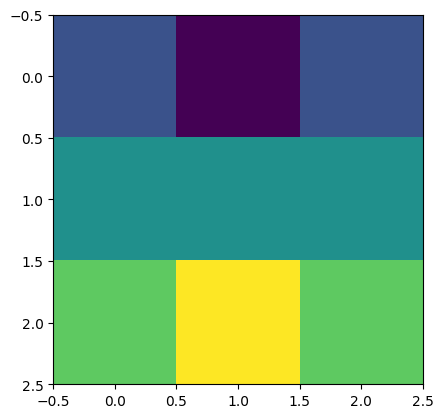

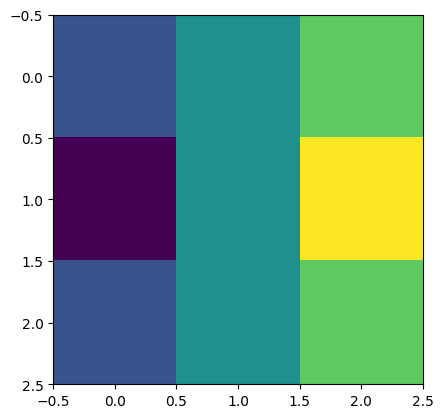

In [8]:
base = np.array([
  [-1, -2, -1],
  [0,0,0],
  [1,2,1],
  ])


print(base)
print(base.T)

plt.imshow(base)
plt.show()
plt.imshow(base.T)
plt.savefig("sobel_kernel.png")
plt.show()

base_x = base[:,:,np.newaxis]
base_y = base.T[:,:,np.newaxis]

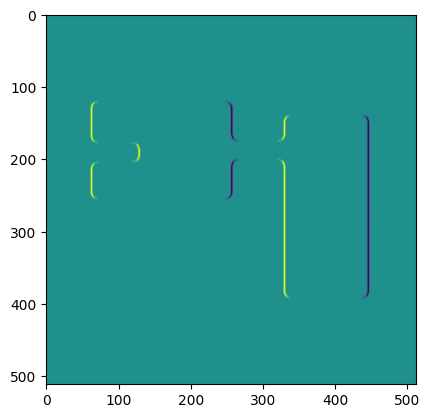

In [9]:
X = cv.Sobel(gs_img, cv.CV_64F, 1, 0, ksize=5)
plt.savefig("sobel_kernel_result.png")
plt.imshow(X)


[0. 1. 2. 3.]


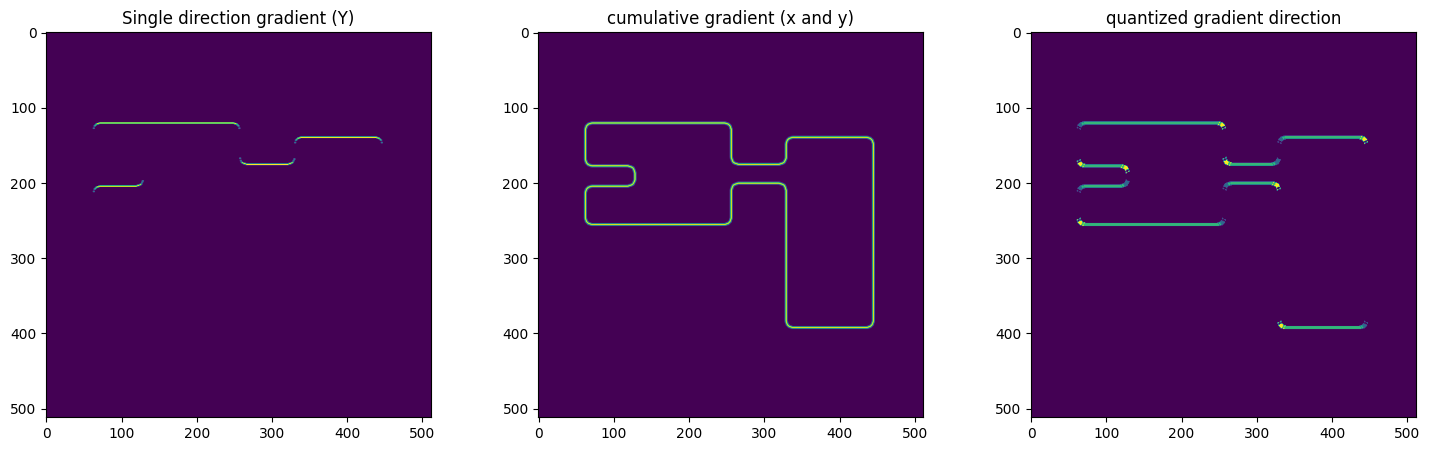

In [10]:
y_grad = cv.filter2D(gs_img,2, base_x)
x_grad = cv.filter2D(gs_img,2, base_y)

def edge_detect(img:np.ndarray) -> np.ndarray:
  x_grad = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
  y_grad = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)

  magnitude = np.sqrt(x_grad**2 + y_grad**2)
  magnitude /= np.max(magnitude)
  gradient_direction = np.arctan2(y_grad, x_grad)
  gradient_direction = (np.round((gradient_direction / np.pi) * 4) + 4) % 4
  
  return magnitude[:,:,np.newaxis], gradient_direction

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

ax1.set_title("Single direction gradient (Y)")
ax1.imshow(y_grad)

magnitude, dir = edge_detect(gs_img)
ax2.set_title("cumulative gradient (x and y)")
ax2.imshow(magnitude)

ax3.set_title("quantized gradient direction")
ax3.imshow(dir)

print(np.unique(dir))
fig.savefig("gradient.png")



In [11]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    M, N, _ = gradient_magnitude.shape
    result = np.zeros((M, N), dtype=np.float16)

    for i in range(1, M - 1): # y
        for j in range(1, N - 1): # x

            # Angle quantization
            if (gradient_direction[i,j]) == 1: # up
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif (gradient_direction[i,j]) == 2: # right
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif (gradient_direction[i,j]) == 3: # down
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            elif (gradient_direction[i,j]) == 0: # left
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            if gradient_magnitude[i, j,0] >= q and gradient_magnitude[i, j,0] >= r:
                result[i, j] = gradient_magnitude[i, j]
            else:
                result[i, j] = 0

    return result[:,:,np.newaxis]

(512, 512, 1)


/tmp/ipykernel_124098/2804604883.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i, j] = gradient_magnitude[i, j]
/tmp/ipykernel_124098/3990258303.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


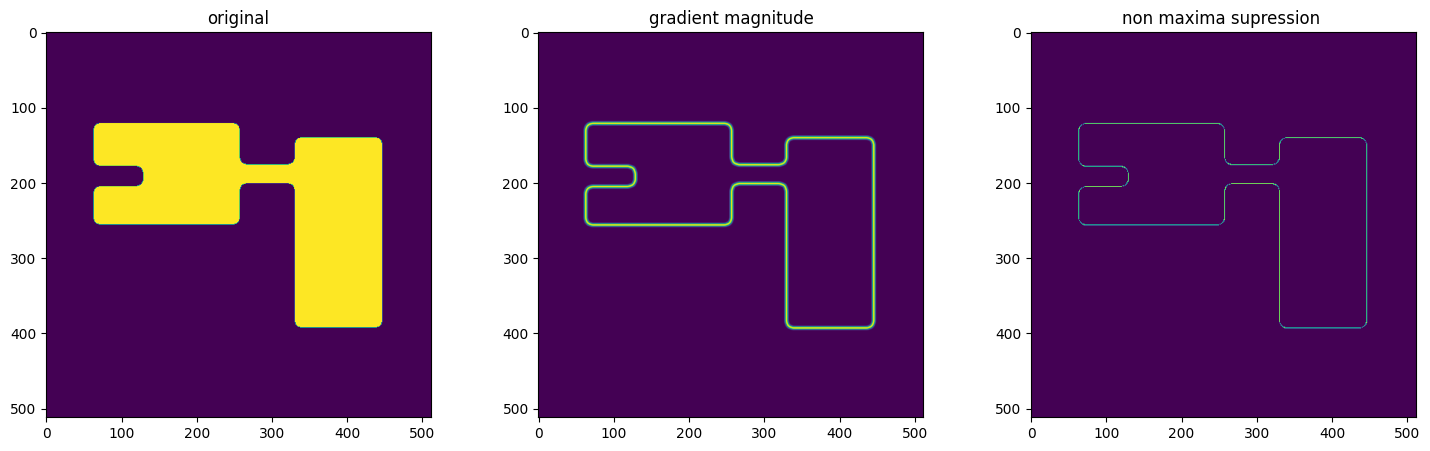

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

ax1.set_title("original")
ax1.imshow(gs_img)

gradient_magnitude, gradient_direction = edge_detect(blur(gs_img))
ax2.set_title("gradient magnitude")
ax2.imshow(gradient_magnitude)
print(gradient_magnitude.shape)


ax3.set_title("non maxima supression ")
supressed = non_max_suppression(gradient_magnitude, gradient_direction)
ax3.imshow(supressed)

fig.savefig("non_maxima.png")
fig.show()


In [13]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    weak_v = np.int32(25)
    strong_v = np.int32(255)

    M, N, _ = img.shape  # Assuming img has shape (h, w, 1)
    strong = np.zeros_like(img, dtype=np.int32 )
    weak = np.zeros_like(img, dtype=np.int32 )
    vis = np.zeros_like(img, dtype=np.int32 )

    img = img.squeeze(axis=-1)  # Remove the singleton dimension

    strong_i, strong_j = np.where(img >= highThreshold)
    strong[strong_i, strong_j, 0] = 1
    vis[strong_i, strong_j, 0] = strong_v

    weak_i, weak_j = np.where(img >= lowThreshold)
    weak[weak_i, weak_j, 0] = 1
    vis[weak_i, weak_j, 0] = weak_v

    return vis, strong, weak-strong




In [14]:
# directions
dirs = np.array([
  [-1, -1],
  [-1, 0],
  [-1, 1],
  [0, 1],
  [1, 1],
  [1, 0],
  [1, -1],
  [0, -1],
])

def double_treshold(weak:np.ndarray, strong:np.ndarray, iterations = 5):
  out = np.zeros_like(strong, np.bool_)
  strong_lookup = np.zeros_like(strong).squeeze()
  strong_lookup = np.bitwise_or(strong_lookup, strong == 1.0)


  for i in range(iterations):
    strong_lookup = np.bitwise_or(strong_lookup, out)
    for (i, j, _) in np.argwhere(weak == 1.0): # for each weak pixle
      if i == strong.shape[0] - 1 or j == strong.shape[1] - 1: # cleaer boundries
        continue
      for dy, dx in dirs:
        # ckeck weak edges and check if they have strong neighbours
        if(strong_lookup[i + dy, j+dx, 0] == 1.0):
          out[i, j] = 1
          break
    
  return out

### double_treshold
Iterative trasholding for connecting **weak** edges inbetween **strong** onse

NameError: name 'weak' is not defined

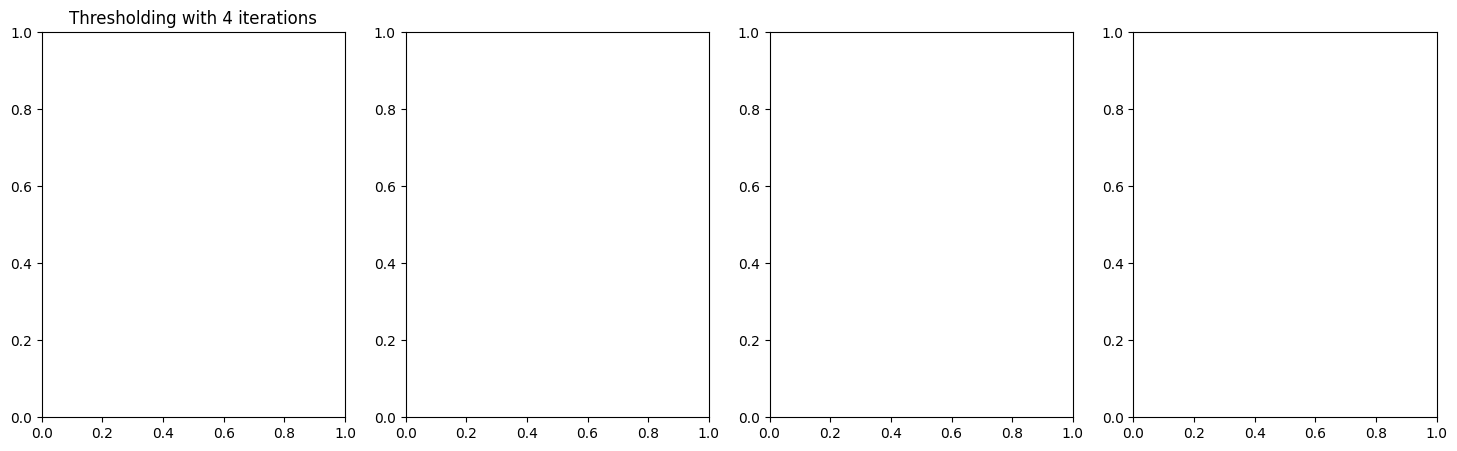

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18, 5))

for i, ax in enumerate(axs):
  iters = 4*(i+1)
  ax.set_title(f"Thresholding with {iters} iterations")
  ax.imshow(double_treshold(weak, strong, iters))
fig.savefig("tresholding.png")
fig.show()


# np.argwhere(weak == 1.0)

# np.sum(np.bitwise_and(weak, strong))

/tmp/ipykernel_124098/2804604883.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i, j] = gradient_magnitude[i, j]


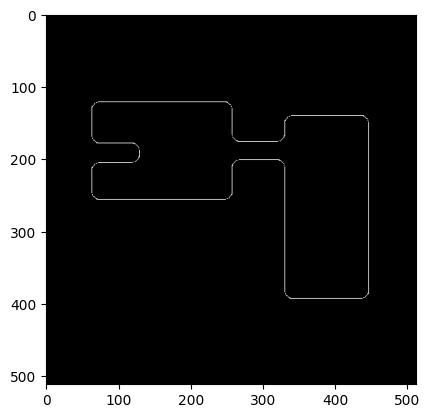

In [17]:
def cany(img:np.ndarray):
  blured = blur(img, 8)
  magnitude, dir = edge_detect(blured)
  supressed = non_max_suppression(magnitude, dir)
  vis, strong, weak= threshold(supressed)
  additional = double_treshold(weak=weak, strong=strong)
  return additional + strong

plt.imshow(cany(gs_img), cmap="gray")

/tmp/ipykernel_4381/2804604883.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i, j] = gradient_magnitude[i, j]


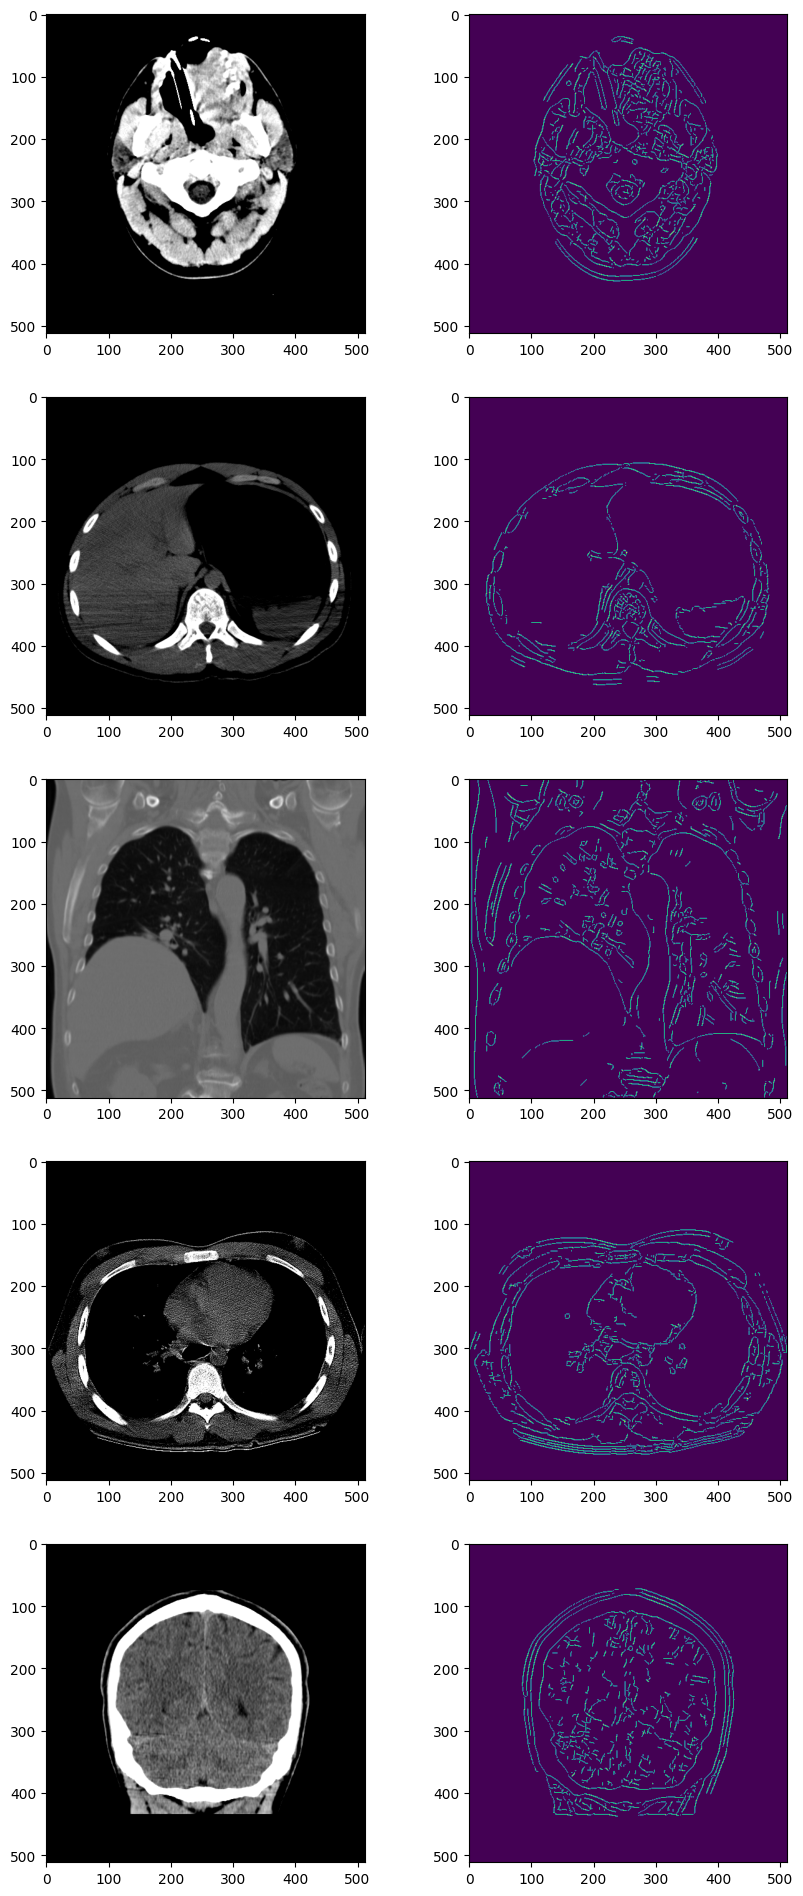

In [ ]:
import os
import glob

images  = [image for image in list(glob.glob("CTMRI/test/*.png"))]
# fig, axs = plt.subplots(ncols=len(images), nrows=2, figsize=(18, 5))
fig, axs = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 24))

for i in range(len(images)):
  image = images[i]
  ax_orig, ax_cany = axs[i][0], axs[i][1]
  img = cv.imread(image)
  gs_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)[:,:,np.newaxis]

  ax_orig.imshow(gs_img, cmap="gray")
  ax_cany.imshow(cany(gs_img))

fig.savefig("results.png")
